# ANSI Application analysis

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plotter
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
def view_boxplot(df):
    %matplotlib
    df.boxplot()
    plotter.show()

## CPU data

In [3]:
cpu_df = pandas.read_csv('data/ansi_fake_data/ansi_fake_data_cpu.csv', index_col='Time').drop('Unnamed: 0', axis=1)

In [4]:
#cpu_df.columns

In [5]:
#view_boxplot(cpu_df)

## Network TX

In [6]:
txnet_df = pandas.read_csv('data/ansi_fake_data/ansi_fake_data_network_tx.csv', index_col='Time').drop('Unnamed: 0', axis=1)

In [7]:
#txnet_df.columns

In [8]:
#view_boxplot(txnet_df)

## Network RX

In [9]:
rxnet_df = pandas.read_csv('data/ansi_fake_data/ansi_fake_data_network_rx.csv', index_col='Time').drop('Unnamed: 0', axis=1)

In [10]:
#rxnet_df.columns

In [11]:
rxnet_df = rxnet_df.clip(lower=0, upper=15000)
#view_boxplot(rxnet_df)

## Disk IO data

In [12]:
disk_df = pandas.read_csv('data/ansi_fake_data/ansi_fake_data_disk_io.csv', index_col='Time').drop('Unnamed: 0', axis=1)

In [13]:
#disk_df.columns

In [14]:
disk_df = disk_df.clip(lower=0, upper=4000)
#view_boxplot(disk_df)

## Context switching

In [15]:
context_df = pandas.read_csv('data/ansi_fake_data/ansi_fake_data_context.csv', index_col='Time').drop('Unnamed: 0', axis=1)

In [16]:
#context_df.columns

In [17]:
context_df = context_df.clip(lower=0, upper=5000)
#view_boxplot(context_df)

## Seperate into proper dataframes for each node

In [18]:
dframes = [cpu_df, txnet_df, rxnet_df, context_df, disk_df]
node = {}

for i in range(1,5):
    frames = []
    
    for dframe in dframes:
        columns = list(filter(lambda x: f'bb{i}l' in x, dframe.columns))
        frames.append(dframe[columns])

    node[i] = pandas.concat(frames, join='inner', axis=1).fillna(0)[:38200]

In [19]:
for i in range(1,5):
    print(node[i].shape)
    
print(node[1].columns)

(38200, 29)
(38200, 29)
(38200, 29)
(38200, 29)
Index(['cpu_value host bb1localdomain type_instance idle',
       'cpu_value host bb1localdomain type_instance interrupt',
       'cpu_value host bb1localdomain type_instance nice',
       'cpu_value host bb1localdomain type_instance softirq',
       'cpu_value host bb1localdomain type_instance steal',
       'cpu_value host bb1localdomain type_instance system',
       'cpu_value host bb1localdomain type_instance user',
       'cpu_value host bb1localdomain type_instance wait',
       'interface_tx host bb1localdomain instance lo type if_dropped',
       'interface_tx host bb1localdomain instance lo type if_errors',
       'interface_tx host bb1localdomain instance lo type if_octets',
       'interface_tx host bb1localdomain instance lo type if_packets',
       'interface_tx host bb1localdomain instance wlan0 type if_dropped',
       'interface_tx host bb1localdomain instance wlan0 type if_errors',
       'interface_tx host bb1localdomain

## Get data

In [20]:
data_matrices = []

for i in range(1,5):
    data_matrices.append(node[i].as_matrix())
    
data = numpy.vstack(data_matrices)

In [21]:
data.shape

(152800, 29)

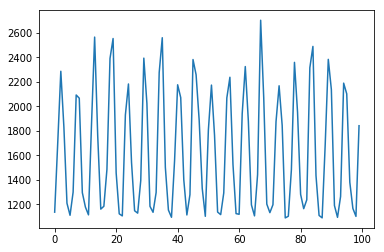

(152800, 29)


In [22]:
tdata = data[:,24]
plotter.plot(tdata.T[:100])
plotter.show()
print(data.shape)

In [23]:
#data = data[:,24]

## Prepare scaler

In [24]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
scaler = MinMaxScaler()

In [25]:
scaler.fit(data)
del data

---

## Correrlation measurement

---

------

-----

# Prediction

In [26]:
for i in range(len(data_matrices)):
    
    transformed = scaler.transform(data_matrices[i])
    data_matrices[i] = transformed

X = numpy.stack(data_matrices[:-1], axis=1)
test_X = numpy.array([data_matrices[3]])
test_X[0,50,0] = 1.0
#x_val = numpy.array([data_matrices[2]])

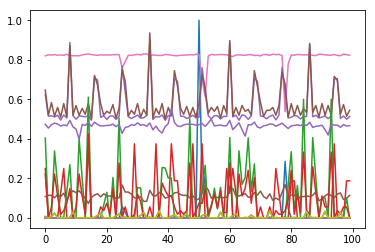

In [27]:
plotter.plot(test_X.squeeze()[:100])
plotter.show()

In [28]:
print(X.shape)
LEN = X.shape[0]
SPLIT = int(0.9*LEN)

train_X = X[:SPLIT,:,:]
val_X = X[SPLIT:SPLIT+1000,:,:]
test_X = X[SPLIT+1000:,:,:]

(38200, 3, 29)


In [29]:
X = train_X
X = numpy.transpose(X, (1, 0, 2))
#X = X.reshape((-1,382,29))
val_X = numpy.transpose(val_X, (1, 0, 2))
test_X = numpy.transpose(test_X, (1, 0, 2))
#val_X = val_X.reshape((-1,382,29))
print(X.shape)
print(val_X.shape)

(3, 34380, 29)
(3, 1000, 29)


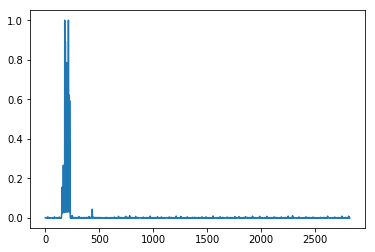

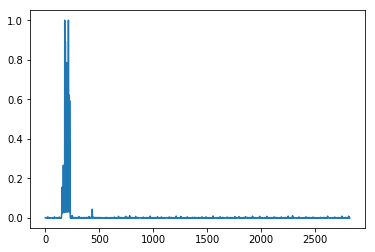

In [30]:
plotter.plot(test_X[0][:,25])
plotter.show()
#test_X[0][:,25] = 0.0
#test_X[0][:,28] = 0.0
plotter.plot(test_X[0][:,25])
plotter.show()

In [31]:
def flat_generator(X, tsteps = 5, ravel=1):
    i = 0
    
    while True:
        batch_X = X[:,i:i+tsteps,:]
        batch_y = X[:,i+tsteps,:]
            
        if ravel:
            batch_X = batch_X.reshape((batch_X.shape[0], -1))
        #print(batch_X.shape)
        #print(batch_y.shape)
        
        yield batch_X, batch_y
        
        i += 1
        if i > (X.shape[1] - tsteps - 1):
            i = 0
            continue

In [32]:
TIMESTEPS = 5
DIM = 29
tgen = flat_generator(X, TIMESTEPS, 0)
vgen = flat_generator(val_X, TIMESTEPS, 0)

## Flat models

### Linear Regression

In [33]:
from keras.models import Model
from keras.layers import Dense, Input, Dropout, GRU
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [34]:
input_layer = Input(shape=(TIMESTEPS,DIM))
hidden = GRU(20, activation='relu', return_sequences=True)(input_layer)
hidden = GRU(10, activation='relu', return_sequences=True)(hidden)
hidden = GRU(5, activation='relu')(hidden)
hidden = Dropout(0.1)(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [35]:
model = Model(input_layer, output)

In [36]:
estopper = EarlyStopping(patience=10, min_delta=0.0001)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

Epoch 1/10000
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0935 - mean_absolute_error: 0.0935 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 2/10000
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0325 - mean_absolute_error: 0.0325 - val_loss: 0.0175 - val_mean_absolute_error: 0.0175
Epoch 3/10000
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0253 - mean_absolute_error: 0.0253 - val_loss: 0.0186 - val_mean_absolute_error: 0.0186
Epoch 4/10000
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0245 - mean_absolute_error: 0.0245 - val_loss: 0.0155 - val_mean_absolute_error: 0.0155
Epoch 5/10000
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0145 - val_mean_absolute_error: 0.0145
Epoch 6/10000
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0220 - mean_absolute_error: 0.0220 - val_loss: 0.0142 - val_mean_absol

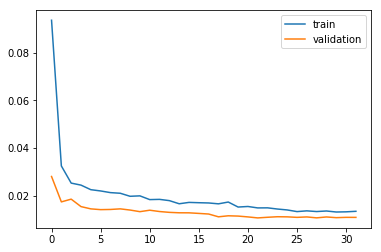

In [37]:
history = model.fit_generator(tgen, steps_per_epoch=1000, epochs=10000, callbacks=[estopper], shuffle=False, validation_data=vgen, validation_steps=1000)
plotter.plot(history.history['loss'],label='train')
plotter.plot(history.history['val_loss'],label='validation')
plotter.legend()
plotter.show()

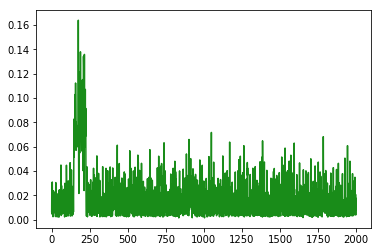

0.0172758678524


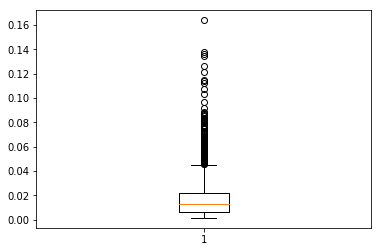

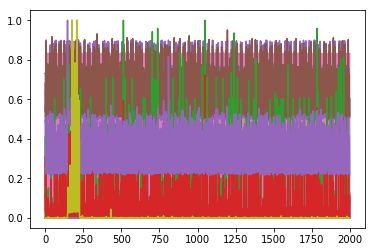

In [38]:
test_gen = flat_generator(numpy.array([test_X[0]]), TIMESTEPS,0)
error = []
targets = []
preds = []
for i in range(2000):
    _input,target = next(test_gen)
    
    if i != 0:
        #print(_input.shape)
        _input = _input.squeeze()[1:,:]
        #print(_input.shape)
        _input = numpy.append(pred,_input, axis=0)[numpy.newaxis,:,:]
        #print(_input.shape)
        
    targets.append(target.squeeze())
    pred = model.predict(_input)
    #print(target.shape)
    #print(pred.shape)
    preds.append(pred.squeeze())
    error.append(mean_absolute_error(y_pred=pred, y_true=target))

targets = numpy.vstack(targets)
preds = numpy.vstack(preds)

plotter.plot(error, 'g-', alpha=0.9)
plotter.show()
error = numpy.array(error)
print(numpy.mean(error))
plotter.boxplot(error)
plotter.show()
plotter.plot(targets)
plotter.show()
#print(error)

(2820, 29)


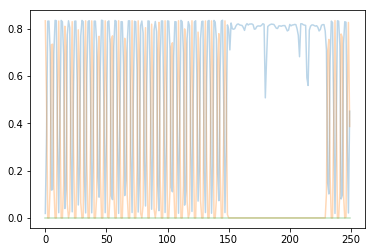

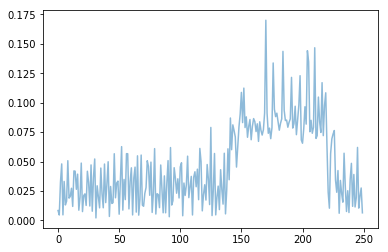

In [49]:
print(test_X[0].shape)
plotter.plot(test_X[0][:250,6], alpha=0.3)
plotter.plot(test_X[0][:250,0], alpha=0.3)
plotter.plot(test_X[0][:250,20], alpha=0.3)
plotter.show()
plotter.plot(error[:250], alpha=0.5)
plotter.show()

(34380, 29)


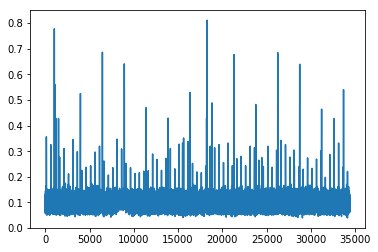

In [41]:
print(X[0].shape)
plotter.plot(X[0][:,5])
plotter.show()